In [616]:
from dateutil.parser import parse 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet as pr
#import mplcursors
from datetime import datetime

In [617]:
import warnings
warnings.filterwarnings("ignore")

In [618]:
sns.set_style("darkgrid")
%matplotlib inline

## Carregando Base de Dados, Dividindo entre Teste e Treino e Alterando para Padrão Prophet


In [781]:
rainfall = pd.read_csv(r"C:\Users\Matheus Alves\OneDrive\Documentos\GIT\TCC\time_series_precipitation\Dataset\dados_chuvas1.csv", parse_dates=True)

In [782]:
rainfall['Date'] = pd.to_datetime(rainfall['Date'], format="%Y/%m/%d")
rainfall['month'] = pd.DatetimeIndex(rainfall.Date).month
#rainfall['Date'] = rainfall['Date'].dt.strftime('%Y-%m')

In [783]:
train = rainfall.iloc[:-14]
test = rainfall.iloc[-14:]
test = test.drop(columns = ['month'])

## Instanciando Prophet e Fazendo uma Previsão com Ajustes Para o Verão e Sazonalidade Quadrimestral

In [717]:

rainfall_jan = train[(train.month == 1)]
rainfall_fev = train[(train.month == 2)]
rainfall_mar = train[(train.month == 3)]
rainfall_oc = train[(train.month == 10)]
rainfall_nov = train[(train.month == 11)]
rainfall_dec = train[(train.month == 12)]

all_dfs = [rainfall_jan,rainfall_fev,rainfall_mar, rainfall_oc, rainfall_nov,rainfall_dec]

rainfall_summer = pd.concat(all_dfs).reset_index(drop=True)
rainfall_summer = rainfall_summer.drop(columns = ['month'])

In [718]:
train = train.drop(columns = ['month']) 
train.columns = ['ds','y']

In [719]:
#adicionando os meses de verão para uma previsão mais precisa
summer = pd.DataFrame({'holiday': 'summer',
                       'ds': rainfall_summer['Date']})

In [720]:
model = pr(yearly_seasonality=100, daily_seasonality=False, holidays=summer, weekly_seasonality=False, seasonality_mode='additive')
model.add_seasonality('quarterly', period=91.25, fourier_order = 10, mode='additive')
model.fit(train)
future = model.make_future_dataframe(periods=14, freq='M')

14:25:06 - cmdstanpy - INFO - Chain [1] start processing
14:25:06 - cmdstanpy - INFO - Chain [1] done processing


In [721]:
rainfall_pred = model.predict(future)


## Visualizando os Dados da Série Global e a Comparação entre Teste e Previsão

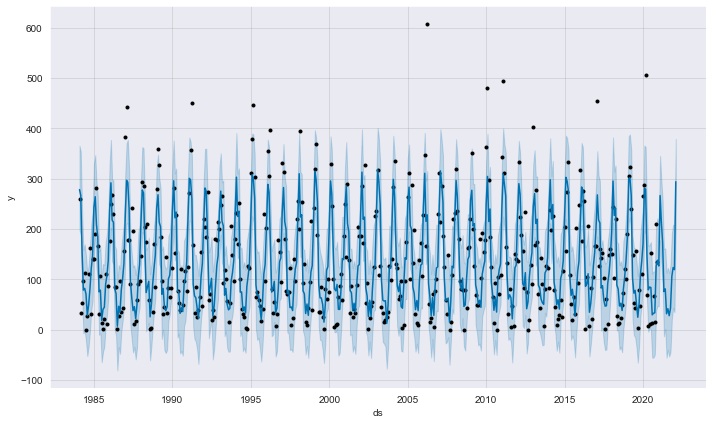

In [722]:
final_model = model.plot(rainfall_pred)

## Visualizando os Dados da Série Global e a Comparação entre Teste e Previsão

In [723]:
previsao = rainfall_pred[['ds','yhat']].iloc[-14:]
previsao.columns = ['Date','Precipitation']
previsao = previsao.round(1)

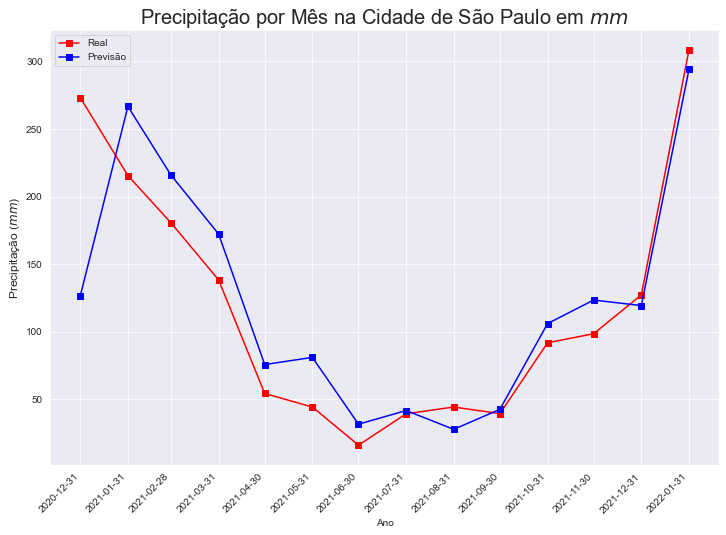

In [724]:
fig = plt.figure(figsize=(12, 8))

plt.plot(test.Date, test.Precipitation, 's-r')
plt.plot(previsao.Date, previsao.Precipitation, 's-b')

plt.title('Precipitação por Mês na Cidade de São Paulo em $mm$', fontsize=20)

plt.ylabel('Precipitação ($mm$)', fontsize=12)
plt.xlabel('Ano')
plt.legend(['Real', 'Previsão']);

import matplotlib.dates as mdates 
months = mdates.MonthLocator(interval=1, bymonthday=-1)  
plt.gca().xaxis.set_major_locator(months) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) 
plt.xticks(rotation=45, ha='right') 
plt.show()

In [725]:
previsao #valores previstos pelo modelo

,Date,Precipitation
443,2020-12-31,126.6
444,2021-01-31,266.6
445,2021-02-28,215.9
446,2021-03-31,172.3
447,2021-04-30,75.8
448,2021-05-31,81.1
449,2021-06-30,31.7
450,2021-07-31,41.8
451,2021-08-31,27.9
452,2021-09-30,42.7


In [784]:
test #valores utilizados para prever o modelo

,Date,Precipitation
443,2020-12-31,273.2
444,2021-01-31,215.5
445,2021-02-28,180.6
446,2021-03-31,138.4
447,2021-04-30,54.4
448,2021-05-31,44.4
449,2021-06-30,16.2
450,2021-07-31,39.4
451,2021-08-31,44.4
452,2021-09-30,39.5


# Avaliando o Modelo

In [751]:
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError

In [752]:
real_value = np.array(test['Precipitation'])
pred_value = np.array(previsao['Precipitation'])

In [763]:
train['Precipitation']

0      259.3
1       32.5
2       54.0
3       96.8
4      113.0
       ...  
438     12.6
439     66.2
440     14.6
441    210.2
442    135.4
Name: Precipitation, Length: 443, dtype: float64

In [786]:
smape = MeanAbsolutePercentageError(symmetric=True)
smape(real_value, pred_value) * 100


27.006291807541334

In [767]:
mase = MeanAbsoluteScaledError()
mase(real_value, pred_value, y_train = train['Precipitation'])


0.32381579358120266

In [769]:
#substituindo o valor de teste pela média de dezembro e refazendo o gráfico
test.at[443,'Precipitation'] = 220

In [777]:
test

,Date,Precipitation
443,2020-12-31,220.0
444,2021-01-31,215.5
445,2021-02-28,180.6
446,2021-03-31,138.4
447,2021-04-30,54.4
448,2021-05-31,44.4
449,2021-06-30,16.2
450,2021-07-31,39.4
451,2021-08-31,44.4
452,2021-09-30,39.5


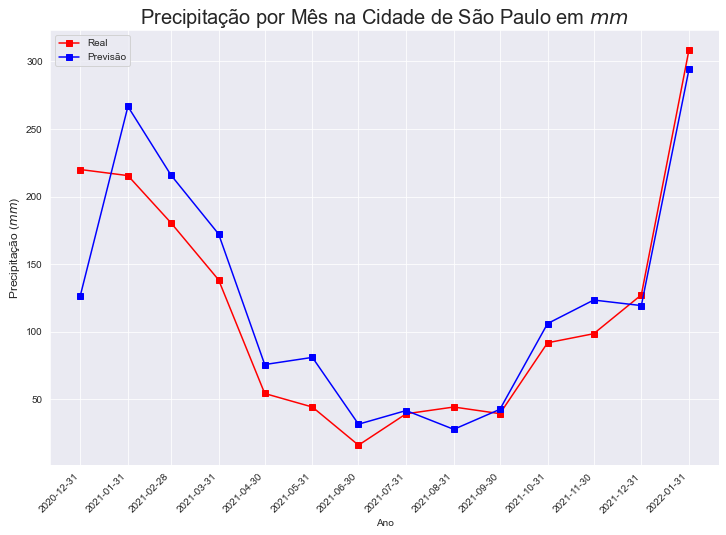

In [732]:
fig = plt.figure(figsize=(12, 8))

plt.plot(test.Date, test.Precipitation, 's-r')
plt.plot(previsao.Date, previsao.Precipitation, 's-b')

plt.title('Precipitação por Mês na Cidade de São Paulo em $mm$', fontsize=20)

plt.ylabel('Precipitação ($mm$)', fontsize=12)
plt.xlabel('Ano')
plt.legend(['Real', 'Previsão']);

import matplotlib.dates as mdates 
months = mdates.MonthLocator(interval=1, bymonthday=-1)  
plt.gca().xaxis.set_major_locator(months) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) 
plt.xticks(rotation=45, ha='right') 
plt.show()

In [733]:
real_value = np.array(test['Precipitation'])
smape(real_value, pred_value) * 100

27.006291807541334

In [768]:
mase = MeanAbsoluteScaledError()
mase(real_value, pred_value, y_train = train['Precipitation'])

0.32381579358120266